# Fotomontaż czystej klatki – Raport i Analiza
Autorzy: Dominik Maćkowiak 151915, Szymon Szymankiewicz 151821

W tym projekcie stworzymy tzw. „czystą klatkę” (clean plate) z ciągu zdjęć tego samego obiektu/sceny, usuwając z nich obiekty ruchome, czyli w tym przypadku ludzi i szumy. Notatnik zawiera zarówno kod, jak i szczegółowe opisy kolejnych kroków, wizualizacje pośrednich wynikówo oraz omówienie ich trafności.

## Krok 1: Przygotowanie środowiska i wczytanie bibliotek

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Krok 2: Wczytywanie obrazów wejściowych

Wczytujemy serię zdjęć, która posłuży do stworzenia czystej klatki. Kluczowe jest zachowanie kolejności i poprawne przekształcenie do formatu RGB.

- **load_image(path)**: wczytuje obraz z pliku i konwertuje BGR→RGB.
- **show_img(image, description)**: ułatwia szybkie wyświetlanie obrazów w notebooku.

> *Wizualizujemy wszystkie obrazy, by ocenić różnorodność sceny oraz zakres ruchu obiektów.*

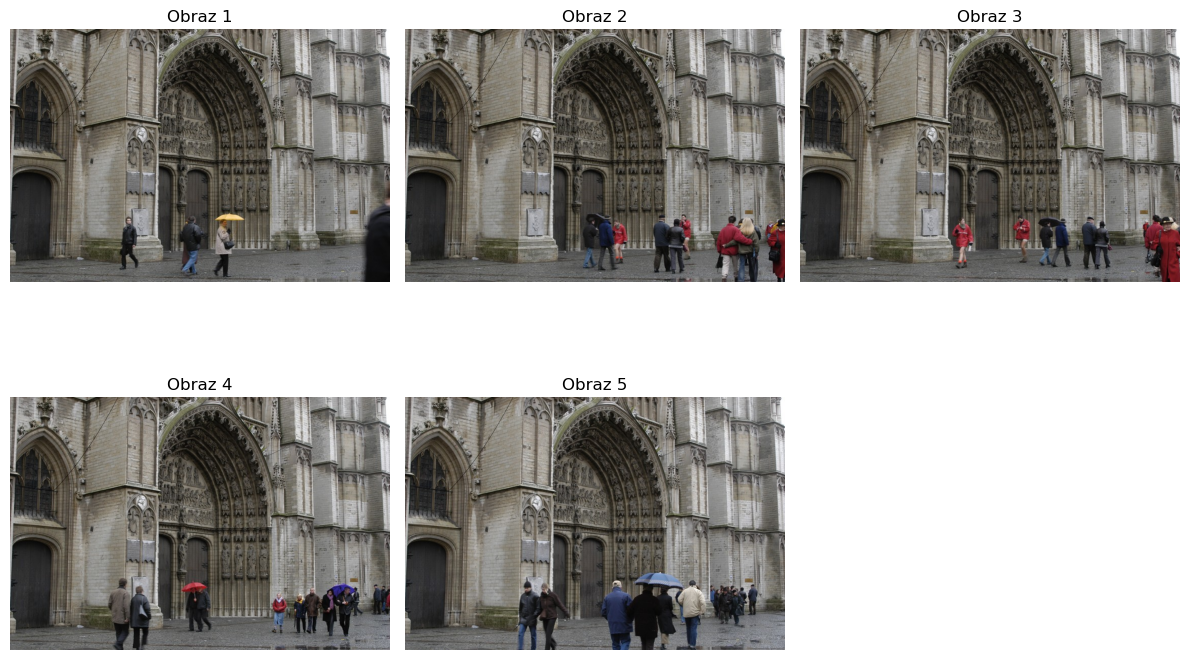

In [2]:
# Definicja funkcji wczytujących i wyświetlających obrazy
def load_image(path: str) -> np.ndarray:
    """
    Wczytaj obraz z podanej ścieżki i przekonwertuj na RGB.
    """
    image = cv2.imread(path)  # OpenCV wczytuje w BGR
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Konwersja do RGB

def show_img(image: np.ndarray, description: str = 'Image') -> None:
    # Wyświetlanie obrazu z opisem
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(description)
    plt.axis('off')
    plt.show()

# Wczytanie wszystkich plików z folderu 'cathedral'
folder_path = 'cathedral'  # Upewnij się, że katalog istnieje
image_paths = [os.path.join(folder_path, f) for f in sorted(os.listdir(folder_path))]
# Wczytanie obrazów do listy
images: list[np.ndarray] = []
for path in image_paths:
    try:
        img = load_image(path)
        images.append(img)
    except Exception as e:
        print(f'Błąd przy wczytywaniu {path}:', e)
        raise

# Wyświetlenie wczytanych obrazów
plt.figure(figsize=(12, 8))
for i, img in enumerate(images):
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f'Obraz {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()  # Powinno pokazać wszystkie obrazy wejściowe

## Krok 3: Obliczanie mapy energii (opcja seam carving)

**Cel:** Zidentyfikowanie obszarów o niskiej i wysokiej zmianie intensywności, co pomoże w selektywnym łączeniu obrazów na ścieżkach o najmniejszej „energii”.

- Używamy operatora Sobela, by uzyskać pochodne poziome i pionowe.
- Energia = |Sobel_x| + |Sobel_y|.

> *Wizualizacja mapy energii pozwala ocenić, czy algorytm będzie faworyzował obszary gładkie (tło) nad obszarami teksturowanymi (detale).*

In [7]:
def compute_energy(image: np.ndarray) -> np.ndarray:
    """
    Oblicz mapę energii obrazu przy pomocy operatora Sobela.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    return np.abs(sobel_x) + np.abs(sobel_y)  # Mapa energii

## Krok 4: Minimalizacja energii – tworzenie czystej klatki (wersja seam carving)

**Opis:** Iteracyjnie łączymy kolejne obrazy z dotychczasową czystą klatką, wybierając piksele z obrazu, który ma niższą energię w danym miejscu.

- Inicjalizacja: czysta klatka = pierwszy obraz.
- Dla każdego kolejnego obrazu porównujemy mapy energii, tworzymy maskę, a następnie aktualizujemy czystą klatkę.

> *Takie podejście minimalizuje widoczność obiektów ruchomych, wybierając fragmenty o najbardziej jednorodnej strukturze.*

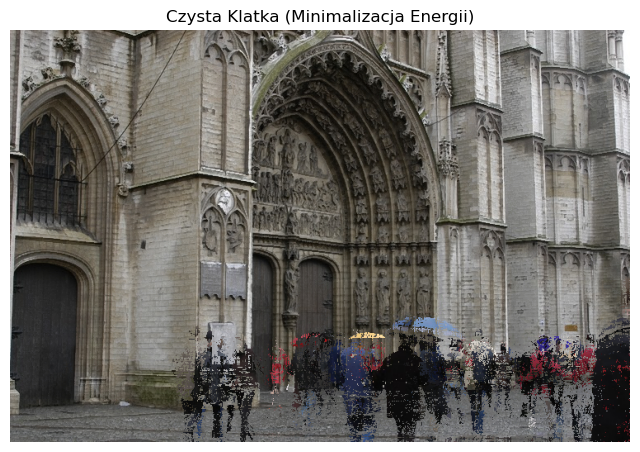

In [8]:
# Sprawdzenie, czy mamy co najmniej dwa obrazy
if len(images) < 2:
    raise ValueError('Wymagane są co najmniej dwa obrazy do tej operacji.')

clean_plate = images[0]  # Inicjalizacja czystej klatki
clean_energy = compute_energy(clean_plate)

for img in images[1:]:
    curr_energy = compute_energy(img)
    mask = curr_energy < clean_energy  # Tam, gdzie energia mniejsza z nowego obrazu
    clean_plate = np.where(mask[..., None], img, clean_plate)
    clean_energy = np.minimum(clean_energy, curr_energy)

# Wyświetlenie wyniku końcowego
show_img(clean_plate, 'Czysta Klatka (Minimalizacja Energii)')  # Sprawdźmy rezultat

Metoda ta dobrze wybiera fragmenty tła, ale może pozostawić artefakty w miejscach o złożonej strukturze teksturowej.

## Krok 5: Mediana – prostszy estimator tła

**Opis:** Tworzymy stos obrazów i obliczamy medianę po wartościach pikseli, co często dobrze usuwa obiekty ruchome, zwłaszcza gdy nie występują one we wszystkich klatkach.

> *Metoda nie wymaga mapy energii i jest szybka, ale może wprowadzać rozmycie, jeśli w scenie występują zmiany o dużym kontraście.*

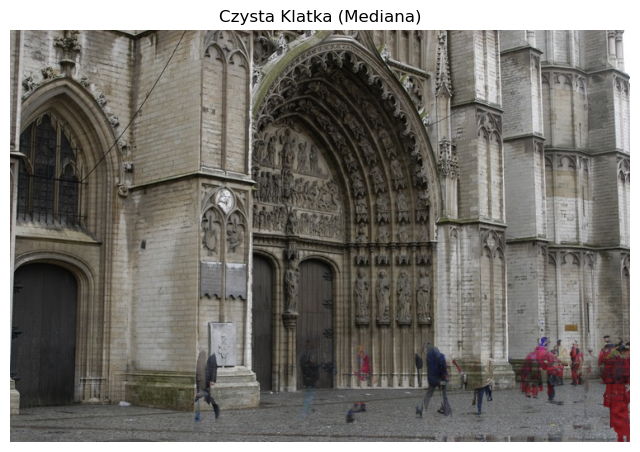

In [5]:
# Stos obrazów (liczba_obrazów, H, W, C)
stack = np.stack(images, axis=0)  # Przygotowanie do uśredniania medianą
# Mediana po osi 0 i konwersja do uint8
clean_plate_med = np.median(stack, axis=0).astype(np.uint8)
# Wyświetlenie wyniku
show_img(clean_plate_med, 'Czysta Klatka (Mediana)')  # Porównajmy z metodą energii

Mediana zazwyczaj dobrze usuwa krótkotrwałe obiekty, ale działa gorzej przy długotrwałych zmianach w scenie.

## Krok 6: Maskowanie ruchu i inpainting

**Cel:** Wykrycie ruchu przez porównanie każdego obrazu z oszacowanym tłem, stworzenie maski ruchu, a następnie wypełnienie tych obszarów algorytmem inpaintingu.

- **Thresholding:** Binaryzacja różnic pikseli.
- **Morfolgia:** Zamknięcie i otwarcie maski usuwają szumy.
- **Inpainting:** Metody TELEA lub Navier-Stokes do uzupełnienia brakujących obszarów.

> *Wynikowy obraz łączy detale tła z otoczenia, bez widocznych obiektów ruchomych.*

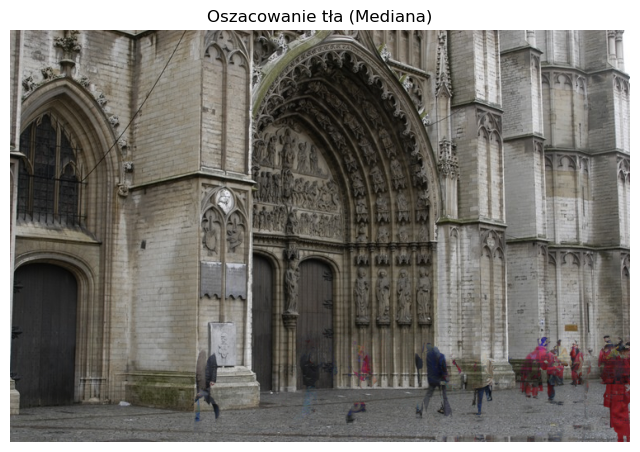

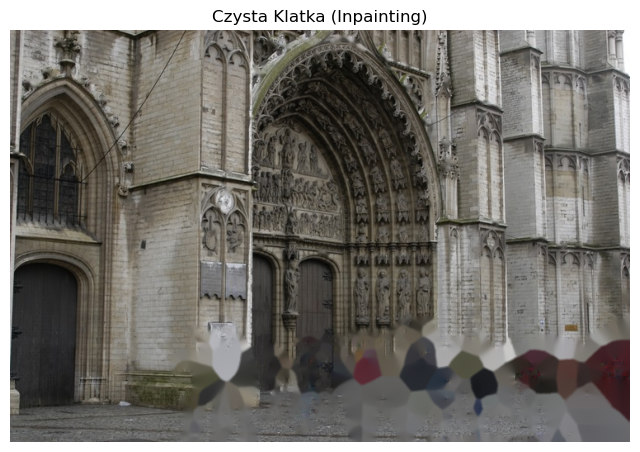

In [6]:
# Parametry
threshold = 30  # Próg do binaryzacji ruchu
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))  # Jądro morfologiczne
# Oszacowanie tła medianą
background = np.median(stack, axis=0).astype(np.uint8)  # Wstępne tło
show_img(background, 'Oszacowanie tła (Mediana)')
# Inicjalizacja maski ruchu
motion_mask = np.zeros(background.shape[:2], dtype=np.uint8)
for img in images:  # Detekcja ruchu po różnicy
    diff = cv2.absdiff(img, background)
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(diff_gray, threshold, 255, cv2.THRESH_BINARY)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Oczyszczenie szumów
    motion_mask = cv2.bitwise_or(motion_mask, mask)  # Akumulacja ruchu
# Inpainting
inpainted = cv2.inpaint(background, motion_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
show_img(inpainted, 'Czysta Klatka (Inpainting)')  # Rezultat

Inpainting dobrze radzi sobie z uzupełnieniem małych dziur, ale przy większych obszarach może wprowadzać nieciągłości.

## Podsumowanie i wnioski

1. **Metoda minimalizacji energii:** precyzyjna, ale może pozostawiać artefakty w skomplikowanych teksturach.
2. **Mediana:** szybka i prosta, skuteczna przy krótkotrwałych obiektach, ale rozmywa detale.
3. **Inpainting:** uzupełnia puste miejsca, ale jakość zależy od rozmiaru maskowanych obszarów.
4. **Rekomendacja:** dla scen z niewielką ilością ruchu – mediana, dla dużej zmienności – seam carving + inpainting.

**Możliwe dalsze prace:** automatyczne dostosowanie parametrów thresholdu, hybrydowe łączenie metod, wykorzystanie sieci neuronowych do segmentacji tła.